## Using a pretrained convnet

    - Extract features using pretrained classifier and feed them to a simple classifier

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Section 1:
    - Load pretrained model

In [3]:
from keras.applications import VGG16

In [4]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Section 2

    - Extracting features using the pretrained convolutional base

In [5]:
import os
import numpy as np

In [6]:
from keras.preprocessing.image import ImageDataGenerator

In [7]:
base_dir = 'D:\Datasets\cats_and_dogs_small'

In [8]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [10]:
# function to extract featuresin bulk

def extract_features(directory, sample_count):
    #declare empty tensors
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    #create a generator
    generator = datagen.flow_from_directory(directory,
                                    target_size=(150, 150),
                                    batch_size=batch_size,
                                    class_mode='binary')
    
    # iterate 
    i = 0  # i is used to index the tensors
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) # get the features for batch
        
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i += 1
        
        if i * batch_size >= sample_count:
            break
            
    return features, labels

In [11]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping 

Found 1000 images belonging to 2 classes.


c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping 

Found 1000 images belonging to 2 classes.


In [12]:
# flatten the feature sets

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

## Section 3
    - densely connected classifier that will use the extracted features

In [13]:

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])


history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6168 - acc: 0.6545 - val_loss: 0.4351 - val_acc: 0.8480
Epoch 2/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.4220 - acc: 0.8175 - val_loss: 0.3577 - val_acc: 0.8720
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3515 - acc: 0.8530 - val_loss: 0.3223 - val_acc: 0.8630
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3134 - acc: 0.8665 - val_loss: 0.2936 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2829 - acc: 0.8870 - val_loss: 0.2774 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2590 - acc: 0.8920 - val_loss: 0.2668 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2467 - acc: 0.8985 - val_loss: 0.2575 - val_acc: 0.8940
Epoch 8/30
200

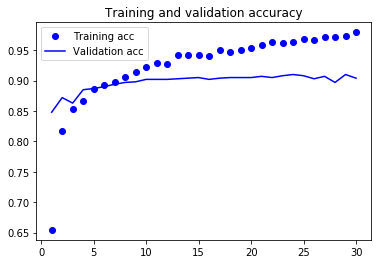

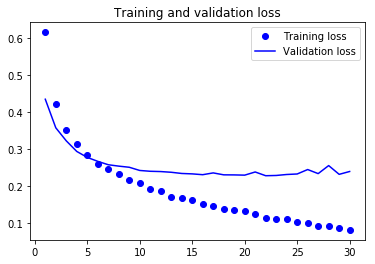

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
    
plt.show()

## FEATURE EXTRACTION WITH DATA AUGMENTATION

    - Adding a densely connected classifier on top of the convolutional base

## Section 1 

    - load the pretrained model and add more layer on top of it

In [9]:
from keras import models
from keras import layers
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [13]:
conv_base.trainable = False

In [14]:
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


-- Doubt : not quite sure why am I getting 30 and 4 in above 3 cells

### Section 2:
    - basic stuff 

In [18]:
import os
base_dir = 'D:\Datasets\cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### Section 3:
    - Preprocess data

In [19]:


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
from keras import optimizers


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

## this is painfully slow

Epoch 1/30


KeyboardInterrupt: 

In [ ]:
model.save('cats_and_dogs_small_3.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()